Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Few-shot Adaptation with Model Agnostic Meta-Learning (MAML)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jaxopt/blob/main/docs/notebooks/implicit_diff/maml.ipynb)


This notebook shows how to use Model Agnostic Meta-Learning (MAML) for few-shot adaptation on a simple regression task. This example appears in section 5.1 of [(Finn et al. 2017)](https://arxiv.org/pdf/1703.03400.pdf). The problem is however solved using *implicit* MAML formulation of [(Rajeswaran et al., 2019)](https://arxiv.org/pdf/1909.04630.pdf).

In [1]:
%%capture
%pip install jaxopt flax matplotlib tqdm

In [2]:
from functools import partial
from typing import Any, Sequence

# activate TPUs if available
try:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
except (KeyError, RuntimeError):
    print("TPU not found, continuing without it.")

from jax.config import config
config.update("jax_enable_x64", True)

import jax
from jax import numpy as jnp
from jax import random
from jax import vmap
from jax.tree_util import Partial, tree_map

from jaxopt import LBFGS, GradientDescent
from jaxopt import linear_solve
from jaxopt import OptaxSolver
from jaxopt import tree_util

import optax

# we use flax to construct a small multi-layer perceptron
from flax import linen as nn
from tqdm.auto import tqdm

# for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

TPU not found, continuing without it.


/home/zramzi/workspace/jaxopt/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# default values 
n_tasks = 4
MIN_X = -5
MAX_X = 5

# amount of L2 regularization. Higher regularization values will promote
# task parameters that are closer to each other.
L2REG = 2  # similar to that of the paper

# for bigger plots
plt.rcParams.update({"figure.figsize": (12, 6)})
plt.rcParams.update({'font.size': 22})

# Problem setup

We consider a multi-task problem, where each task involves regressing from the input to the output of a sine wave. The different tasks have different amplitude and phase of the sinusoid.

In [4]:
def generate_task(key, n_samples_train=6, n_samples_test=6, min_phase=0.5, max_phase=jnp.pi, min_amplitude=0.1, max_amplitude=0.5):
    """Generate a toy 1-D regression dataset."""
    amplitude = random.uniform(key) * (max_amplitude - min_amplitude) + min_amplitude
    
    key, _ = random.split(key)
    phase = random.uniform(key) * (max_phase - min_phase) + min_phase

    key, _ = random.split(key)
    x_train = random.uniform(key, shape=(n_samples_train,)) * (MAX_X - MIN_X) + MIN_X
    x_train = x_train.reshape((-1, 1))  # Reshape to feed into MLP later
    y_train = jnp.sin(x_train - phase) * amplitude

    key, _ = random.split(key)
    x_test = random.uniform(key, shape=(n_samples_test,)) * (MAX_X - MIN_X) + MIN_X
    x_test = x_test.reshape((-1, 1))  # Reshape to feed into MLP later
    y_test = jnp.sin(x_test - phase) * amplitude

    return (x_train, y_train), (x_test, y_test), phase, amplitude


# the above function generates a single task
# the next function should generate a metabatch of tasks in a vectorized fashion (that is without a for loop)
# the tasks should be batched in the first dimension
@partial(jax.jit, static_argnums=(1, 2, 3))
def generate_task_batch(key, meta_batch_size=25, n_samples_train=6, n_samples_test=6, min_phase=0.5, max_phase=jnp.pi, min_amplitude=0.1, max_amplitude=0.5):
    """Generate a batch of toy 1-D regression datasets."""
    keys = random.split(key, meta_batch_size)
    tasks = vmap(
        generate_task,
        in_axes=(0, None, None, None, None, None, None),
    )(keys, n_samples_train, n_samples_test, min_phase, max_phase, min_amplitude, max_amplitude)
    return tasks

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


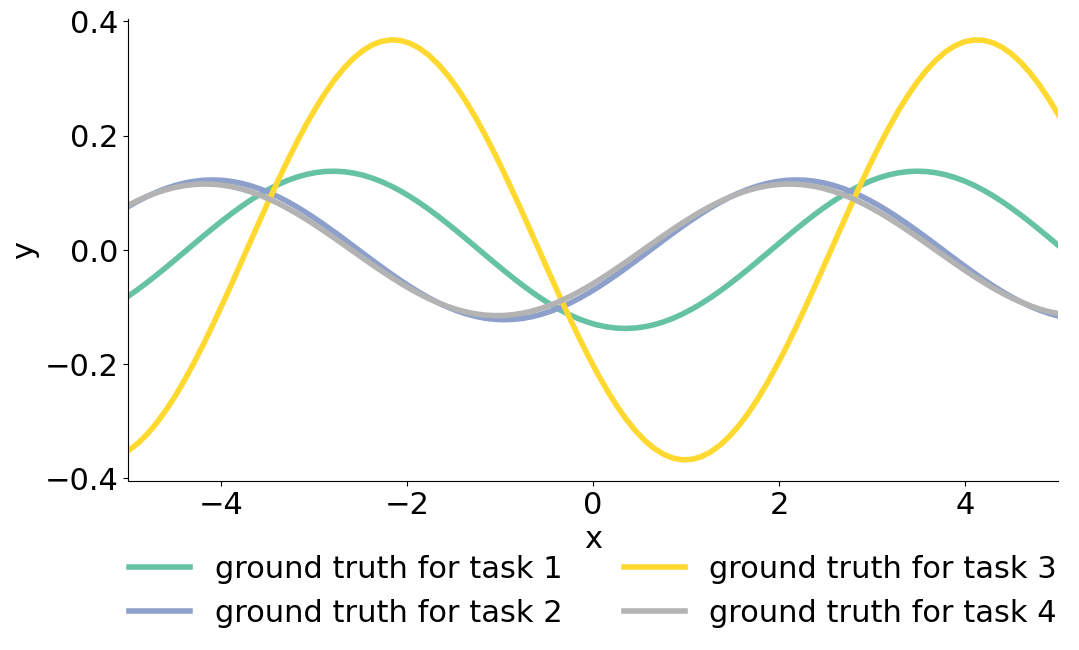

In [5]:
key = random.PRNGKey(0)
fig = plt.figure(figsize=(12, 6))

colors = cm.Set2(jnp.linspace(0, 1, n_tasks))

data_train, data_test, phase, amplitude = generate_task_batch(random.PRNGKey(0), meta_batch_size=n_tasks)
for task in range(n_tasks):

    phase_ = phase[task]
    amplitude_ = amplitude[task]

    # generate the ground truth regression curve for plotting
    xs = jnp.linspace(MIN_X, MAX_X, 100)
    ys = jnp.sin(xs-phase_) * amplitude_
    plt.plot(xs, ys, linewidth=4, label=f'ground truth for task {task+1}', color=colors[task])

plt.xlim((MIN_X, MAX_X))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=2)
# Hide the right and top spines
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We call each one of the curves above a "task". For each task, we have access to 12 samples drawn uniformly, that we split among a train and test set of the same size.

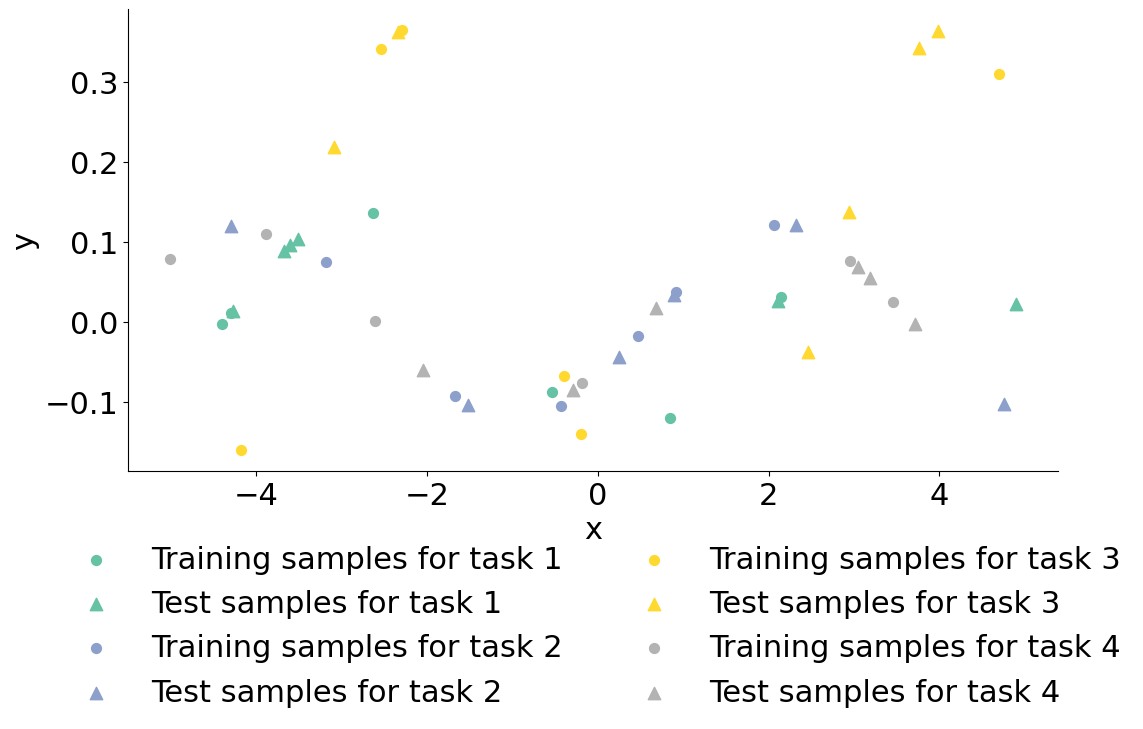

In [6]:
fig = plt.figure(figsize=(12, 6))
for task in range(n_tasks):
    ((x_train, y_train), (x_test, y_test)) = (data_train[0][task], data_train[1][task]), (data_test[0][task], data_test[1][task])
    plt.scatter(x_train, y_train, marker='o', s=50, label=f"Training samples for task {task+1}", color=colors[task])
    plt.scatter(x_test, y_test, marker='^', s=80, label=f"Test samples for task {task+1}", color=colors[task])
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=2)
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()

Let $\mathcal{L_i}$ (resp. $\hat{\mathcal{L_i}}$) denote the the train set (resp. test set) loss of the $i$-th task. Our goal is to learn a set of weights $\theta$ such that a model trained on a new task with the regularized loss $\mathcal{L_i}(\cdot) + \frac{}{}\|\cdot - \theta\|^2$ has a as small generalization error as possible.
[(Rajeswaran et al., 2019)](https://arxiv.org/pdf/1909.04630.pdf) frame this as the following bi-level problem


$$
\text{argmin}_{\theta} \sum_{i=1}^K \hat{\mathcal{L}_i}(x_i(\theta)) \text{ subject to } x_i(\theta) \in \text{argmin}_{x} {\mathcal{L}}_i(x) + \frac{\lambda}{2}\|x - \theta\|^2\,,
$$


In the following cells we'll define the inner objective ${\mathcal{L}}_i(x) + \frac{\lambda}{2}\|x - \theta\|^2$ as ```inner_loss``` and the outer objective $\hat{\mathcal{L_i}}$ as ```outer_loss```. Both losses are a quadratic loss using as predictive model a multi-layer perceptron.

In [7]:
class SimpleMLP(nn.Module):
  features: Sequence[int]
  dtype: Any

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
      x = nn.Dense(
        feat, 
        name=f'layers_{i}', 
        param_dtype=self.dtype,
        
      )(x)
      if i != len(self.features) - 1:
        x = nn.relu(x)
    return x

In [8]:
key, subkey = random.split(random.PRNGKey(0), 2)
dummy_input = random.uniform(key, (1,), dtype=jnp.float64)

model = SimpleMLP(features=[40, 40, 1], dtype=jnp.float64)

The regressor is a neural network model with 2 hidden layers of size 40 with ReLU nonlinearities.

In [9]:
def inner_loss(x, outer_parameters, data, regularization=L2REG):
  # x are the task adapted parameters phi prime in the original paper
  # outer_parameters are the meta parameters, theta bold in the original paper
  samples, targets = data
  prediction = model.apply(x, samples)
  mse = jnp.mean((prediction - targets)**2)  # this is L(phi_prime, D^{tr}_i)
  x_m_outer_parameters = tree_util.tree_add_scalar_mul(x, -1, outer_parameters)
  reg = (regularization / 2) * tree_util.tree_l2_norm(x_m_outer_parameters, squared=True)
  # this \lambda/2 ||phi_prime - theta_bold||^2
  return mse + reg

inner_solver = GradientDescent(
  inner_loss, 
  stepsize=-1,  # using line search
  maxiter=16, 
  tol=1e-12, 
  maxls=15,
  acceleration=False,
  implicit_diff=True,
  implicit_diff_solve=Partial(
      linear_solve.solve_cg,
      maxiter=5,
      tol=1e-7,
  ),
)

def outer_loss(meta_params, data_train, data_test):
  # inner parameters is passed 
  # iterate on the first K-1 tasks
  in_params_sol, _ = vmap(inner_solver.run, (None, None, 0))(
    jax.lax.stop_gradient(meta_params), 
    meta_params, 
    data_train,
  )  # Alg^*(\theta_bold, D^{tr}_i)
  samples_test, targets_test = data_test 
  prediction = vmap(model.apply)(in_params_sol, samples_test)
  loss = jnp.mean((prediction - targets_test)**2)  # L(\phi, D^{te}_i)
  return loss, in_params_sol

In [11]:
key, subkey = random.split(random.PRNGKey(0), 2)

meta_params = model.init(key, dummy_input)


gradient_subopt = []
outer_losses = []

solver = OptaxSolver(
  opt=optax.adam(1e-3), 
  fun=outer_loss, 
  maxiter=1000, 
  has_aux=True,
  tol=1e-6,
)
data_train, data_test, phase, amplitude = generate_task_batch(
  key,
  meta_batch_size=2,
  n_samples_train=10, 
  n_samples_test=10,
)
state = solver.init_state(meta_params, data_train, data_test)

pbar = tqdm(range(solver.maxiter))

for it in pbar:
  key, subkey = random.split(key)
  data_train, data_test, phase, amplitude = generate_task_batch(
    key,
    meta_batch_size=25,
    n_samples_train=10, 
    n_samples_test=10,
  )
  meta_params, state = solver.update(meta_params, state, data_train, data_test)
  outer_losses.append(state.value)
  pbar.set_description(f"Outer loss {state.value:.3f}")

Outer loss 0.004: 100%|██████████| 1000/1000 [00:41<00:00, 24.10it/s]


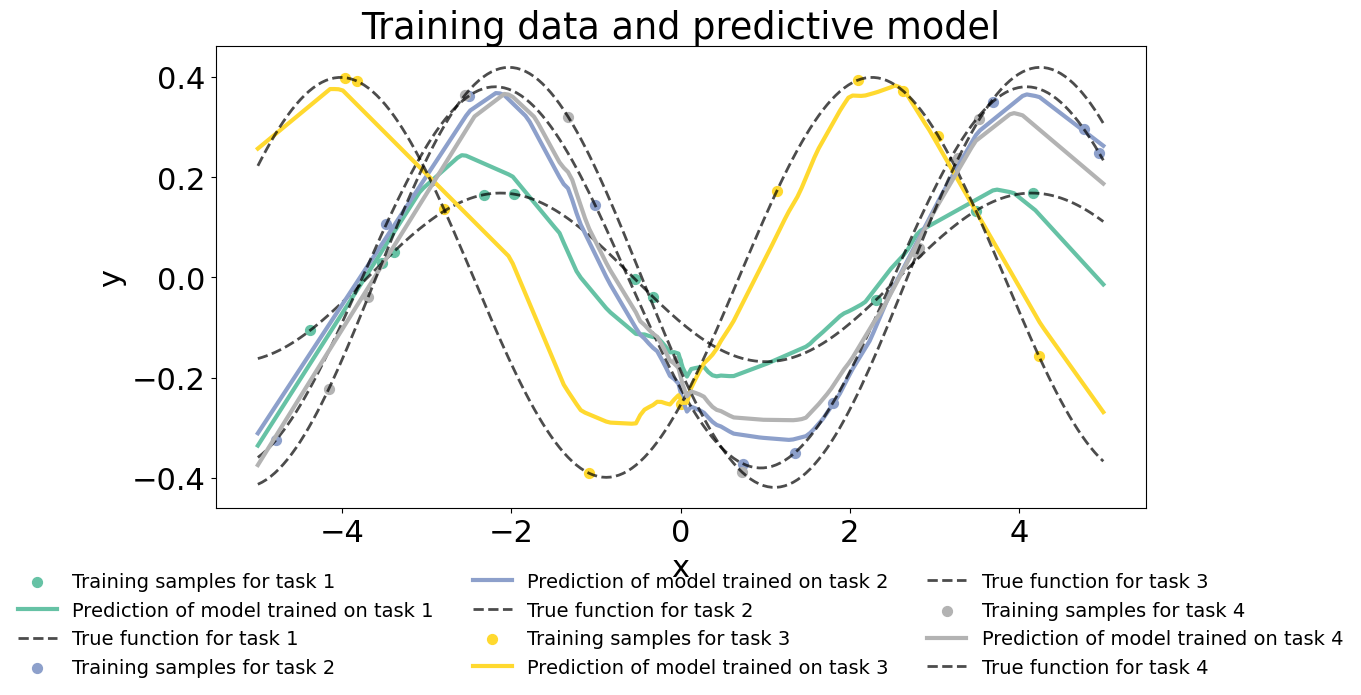

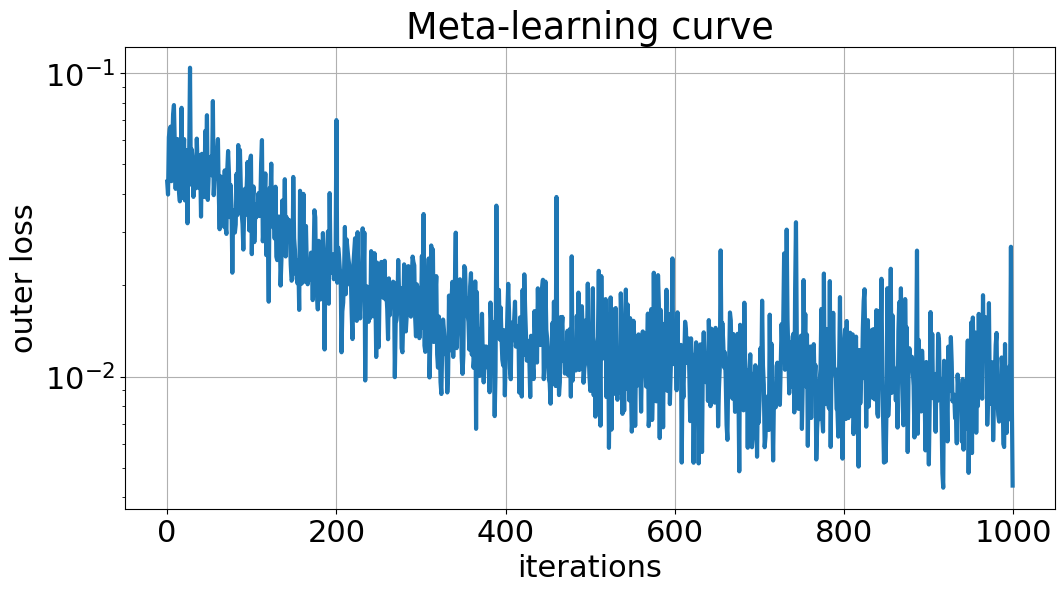

In [12]:
xx = jnp.linspace(MIN_X, MAX_X, 200)
plt.title(f'Training data and predictive model')
for task in range(n_tasks):
    ((x_train, y_train), (x_test, y_test)) = (data_train[0][task], data_train[1][task]), (data_test[0][task], data_test[1][task])
    in_params_sol, _ = inner_solver.run(
        jax.lax.stop_gradient(meta_params), 
        meta_params, 
        (x_train, y_train),
    )
    plt.scatter(x_train, y_train, marker='o', s=50, label=f"Training samples for task {task+1}", color=colors[task])
    prediction = jax.lax.stop_gradient(model.apply(in_params_sol, xx.reshape((-1, 1))))
    plt.plot(xx, prediction.ravel(), color=colors[task], lw=3, label=f"Prediction of model trained on task {task+1}")
    phase_, amplitude_ = phase[task], amplitude[task]
    plt.plot(xx, amplitude_ * jnp.sin(xx - phase_), color="black", lw=2, alpha=0.7, ls='--', label=f"True function for task {task+1}")
plt.legend(loc='upper center', fontsize=14, bbox_to_anchor=(0.5, -0.1), frameon=False, ncol=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.title('Meta-learning curve')
plt.plot(outer_losses, lw=3)
plt.yscale('log')
plt.ylabel("outer loss")
plt.xlabel("iterations")
plt.grid()
plt.show()